In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# Constants
h = 6.602e-34
hbar = h/(2*np.pi)
kB = 1.38e-23
eps_0 = 8.85e-12
c_0 = 299792458
e = 1.602e-19
m_e = 9.109e-31
a_0 = 0.53e-10
norm = 1e9
mu_B = e*hbar/(2*m_e)

In [3]:
#Internal basis vectors expressed in lab frame. SiV high symmetry axis is along z: <111>
x = np.array([-1,1,0])
x = x/np.linalg.norm(x)
y = np.array([-1,-1,2])
y = y/np.linalg.norm(y)
z = np.array([1,1,1])
z = z/np.linalg.norm(z)

#Rotation matrix to switch from internal to external lab frame
R_ext_int = np.vstack((x,y,z)).T
R_int_ext = np.linalg.inv(R_ext_int)

In [18]:
%%latex
Basis states of the system are defined by orbitals $\ket{e_{gx}}, \ket{e_{gy}}, \ket{e_{ux}}, \ket{e_{uy}}$ and spins $\ket{\uparrow}, \ket{\downarrow}$


<IPython.core.display.Latex object>

In [4]:
''' 
    States and operators:
    Orbitals ordering
    0: |e_gx>
    1: |e_gy>
    2: |e_ux>
    3: |e_uy>

    Therefore orbital plus operator L_p_x = |e_g_y><e_g_x| ... 
    Due to D3d symmetry only L_z is non-zero. L_x and L_y vanish.

    Define spin up |🠕> as lower energy state.
'''
N_orbs = 4 
e_g_x = basis(N_orbs, 0)
e_g_y = basis(N_orbs, 1)
e_u_x = basis(N_orbs, 2)
e_u_y = basis(N_orbs, 3)
L_g_p = e_g_y*e_g_x.dag()
L_g_m = L_g_p.trans()
L_e_p = e_u_y*e_u_x.dag()
L_e_m = L_e_p.trans()
L_z_g = 1j*e_g_x*e_g_y.dag()-1j*e_g_y*e_g_x.dag()
L_z_e = 1j*e_u_x*e_u_y.dag()-1j*e_u_y*e_u_x.dag()

N_spins = 2
s_up = basis(N_spins,0)
s_down = basis(N_spins,1)
S_m = s_down*s_up.dag()
S_p = s_up*s_down.dag()
S_x = (S_m + S_p)
S_y = (-1j*S_m + 1j*S_p)
S_z = s_up*s_up.dag() - s_down*s_down.dag()
N = N_orbs*N_spins

In [17]:
%%latex
Orbital Hamiltonian is defined by
$\hat{\mathbb{H}}_\mathrm{Orb} = $ 

<IPython.core.display.Latex object>

In [5]:
'''System Dynamics:
Orbital part comprising Spin-Orbit, Jahn Teller, Zeeman and Strain couplin
'''
HOrb = Qobj(np.zeros((N_orbs, N_orbs)))
HOrb += 1.68*e/h*(e_u_x*e_u_x.dag()+e_u_y*e_u_y.dag())
HOrb = tensor(HOrb, qeye(N_spins))

In [6]:
#Spin-Orbit coupling
SO_g = 46e9
SO_e = 250e9
HSO = -SO_g/2*tensor(L_z_g,S_z) - SO_e/2*tensor(L_z_e,S_z)

In [7]:
#Jahn-Teller coupling
JT_x_g = 0
JT_x_e = 0
JT_y_g = 0
JT_y_e = 0
HJT = JT_x_g*e_g_x*e_g_x.dag()
HJT += JT_y_g*e_g_x*e_g_y.dag()
HJT += JT_y_g*e_g_y*e_g_x.dag()
HJT += -JT_x_g*e_g_y*e_g_y.dag()
HJT += JT_x_e*e_u_x*e_u_x.dag()
HJT += JT_y_e*e_u_x*e_u_y.dag()
HJT += JT_y_e*e_u_y*e_u_x.dag()
HJT += -JT_x_e*e_u_y*e_u_y.dag()
HJT = tensor(HJT, qeye(N_spins))

In [8]:
#Strain coupling
delta_g = 0
alpha_g = 0
beta_g = 0
HStr_g = (delta_g+alpha_g)*e_g_x*e_g_x.dag()
HStr_g += beta_g*e_g_x*e_g_y.dag()
HStr_g += beta_g*e_g_y*e_g_x.dag()
HStr_g += (delta_g-alpha_g)*e_g_y*e_g_y.dag()

delta_e = 0
alpha_e = 0
beta_e = 0
HStr_e = (delta_e+alpha_e)*e_u_x*e_u_x.dag()
HStr_e += beta_e*e_u_x*e_u_y.dag()
HStr_e += beta_e*e_u_y*e_u_x.dag()
HStr_e += (delta_e-alpha_e)*e_u_y*e_u_y.dag()

HStr = HStr_g + HStr_e
HStr = tensor(HStr, qeye(N_spins))

In [11]:
H = HOrb+HSO
energies, eigenstates = H.eigenstates()

# Calculate transformation matrix into eigenbasis
_, sts = np.linalg.eig(H.full())
V = np.array(sts[0])
for st in sts[1:]:
    V = np.vstack((V,st))

def transform_op(op):
    op = op.full()
    return Qobj(np.conj(V.T)@op@V)

def transform_st(st):
    return np.conj(V.T)@st

# Dipole operators
d_x =  e_g_x*e_u_x.dag() - e_g_y*e_u_y.dag()
d_y = -e_g_x*e_u_y.dag() - e_g_y*e_u_x.dag()
d_z =  e_g_x*e_u_x.dag() + e_g_y*e_u_y.dag()

# External (lab) and internal (SiV) polarization of electric laser field
eps_ext = np.array([1,1,1])
eps_ext = 1/np.linalg.norm(eps_ext)*eps_ext
eps_int = np.squeeze(R_int_ext @ eps_ext)
print(eps_int)

# Interaction (Laser) Hamiltonian is constructed within already performed rotating frame transformation and rotating wave approximation.
# In addition, Laser is assumed to be a coherent state and the corresponding photon bath is already traced out, leaving a pure color center Hamiltonian.
Omega_L = 1e9
nu_L = 0
HL = Omega_L*tensor((eps_int[0]*d_x + eps_int[1]*d_y + eps_int[2]*d_z), qeye(N_spins))
HL += HL.dag()


HSys = Qobj()
for i in range(len(energies)):
    if np.abs(energies[i]-nu_L)<1e10:
        HSys += (energies[i]-nu_L)*eigenstates[i]*eigenstates[i].dag()
HSys+HL
# H = transform_op(HSys + HL)
# H = Qobj(H.full().reshape((8,8)), dims=[[4,2],[4,2]])/norm


[ 0.00000000e+00 -5.55111512e-17  1.00000000e+00]


Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.e+00 0.e+00 0.e+00 0.e+00 1.e+09 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+09 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+09 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e+09]
 [1.e+09 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+09 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+09 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+09 0.e+00 0.e+00 0.e+00 0.e+00]]

In [15]:
%%latex
$\vec{a}$

<IPython.core.display.Latex object>

In [74]:
# Environmental interactions
T = 2

n_th_pht = np.exp(-h*energies[4]/(kB*T))
n_th_phn_g = np.exp(-h*46e9/(kB*T))
n_th_phn_e = np.exp(-h*250e9/(kB*T))
print("Mean phonon 46GHz occupation: ", n_th_phn_g)
print("Mean phonon 250GHz occupation: ", n_th_phn_g)
print("Mean photon occupation: ", n_th_pht)

tau_pht_A = 1.7e-9
tau_pht_B = 1.7e-9
tau_pht_C = 1.7e-9
tau_pht_D = 1.7e-9

tau_phn_e = 200e-12
tau_phn_g = 400e-12

c_ops = []

# #C transition
Gamma_C_up = 1/tau_pht_C*(n_th_pht+1)/norm
Gamma_C_down = 1/tau_pht_C*(n_th_pht)/norm
c_ops.append(np.sqrt(Gamma_C_up)*tensor(e_g_x*e_u_x.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_down)*tensor(e_u_x*e_g_x.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_up)*tensor(e_g_y*e_u_y.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_down)*tensor(e_u_y*e_g_y.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_up)*tensor(e_g_x*e_u_y.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_down)*tensor(e_u_y*e_g_x.dag(), qeye(N_spins)))

c_ops.append(np.sqrt(Gamma_C_up)*tensor(e_g_y*e_u_x.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(Gamma_C_down)*tensor(e_u_x*e_g_y.dag(), qeye(N_spins)))

# Transform into other basis
for i, c_op in enumerate(c_ops):
    c_ops[i] = transform_op(c_op)


Mean phonon 46GHz occupation:  0.33276014516096364
Mean phonon 250GHz occupation:  0.33276014516096364
Mean photon occupation:  0.0


In [80]:
transform_op(HSys + HL)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  1.00000000e+09+0.00000000e+00j 0.00000000e+00-5.96046448e-08j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  2.38418579e-07+0.00000000e+00j 0.00000000e+00-1.00000000e+09j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  1.00000000e+09+0.00000000e+00j 0.00000000e+00+5.96046448e-08j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.000000

In [75]:
H

Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

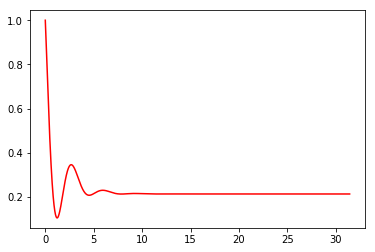

In [76]:
t = np.linspace(0,10*np.pi,5000)
psi0 = tensor(1/np.sqrt(2)*(e_u_x+1j*e_u_y), s_up)
rho0 = psi0*psi0.dag()
options = Options()
options.nsteps = 10000
output = mesolve(H, psi0, t, c_ops, rho0, options=options)
plt.plot(t, output.expect[0], '-r')
plt.show()

In [9]:
#Magnetic field unit vector
e_B_ext = np.array([[1],[1],[0]])
e_B_ext = e_B_ext/np.linalg.norm(e_B_ext)
Bs = np.linspace(0,7,100)

energies = np.zeros((N, len(Bs)))
for i, B in enumerate(Bs):

    #Zeeman coupling with quenching factor of f=0.1
    f = 0.1
    gamma_S = 2*mu_B/h
    gamma_L = mu_B/h
    
    B_ext = e_B_ext*B
    
    #Rotate into SiV internal coordinate system defined by applying (R_y*R_z)^-1
    B_x = np.squeeze(R_int_ext @ B_ext)[0]
    B_y = np.squeeze(R_int_ext @ B_ext)[1]
    B_z = np.squeeze(R_int_ext @ B_ext)[2]
        
    HZL = f*gamma_L*B_z*tensor((L_z_g+L_z_e),qeye(N_spins))    
    HZS = gamma_S*tensor(qeye(N_orbs),(B_x*S_x+B_y*S_y+B_z*S_z))
        
    energies[:,i] = (HOrb+HSO+HZL+HZS+HJT+HStr).eigenenergies()

In [ ]:
labels = [
    '|e_g_x, 🠕>',
    '|e_g_x, 🠗>',
    '|e_g_y, 🠕>',
    '|e_g_y, 🠗>',
    '|e_u_x, 🠕>',
    '|e_u_x, 🠗>',
    '|e_u_y, 🠕>',
    '|e_u_y, 🠗>']
colors = [
    'k',
    'k',
    'r',
    'r',
    'b',
    'b',
    'y',
    'y'
]
styles = [
    '-',
    '-.',
    '-',
    '-.',
    '-',
    '-.',
    '-',
    '-.',
]

fig, axs = plt.subplots(3,1,True)
for i, energy in enumerate(energies):
    if i<4:
        axs[1].plot(Bs, energy, linestyle=styles[i], label=labels[i], color=colors[i])
    else:
        axs[0].plot(Bs, energy-1.68*e/h, linestyle=styles[i], label=labels[i], color=colors[i])
    
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
#Fluorescence spectrum
tlist = np.linspace(0, 0.5e-6, 5000)
corr = correlation_2op_1t(H, None, tlist, c_ops, tensor(e_u_y*e_u_x.dag(),qeye(N_spins)), tensor(e_u_x*e_u_y.dag(),qeye(N_spins)))
wlist1, spec1 = spectrum_correlation_fft(tlist, corr)

fig, ax = plt.subplots(1, 1)
ax.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=1, label='eseries method')
plt.show()
